<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/main/template-report-Stokes-AMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

This report looks at how the solution to the adjoint problem of the Stokes equations change with different input data to the functional and with different placements of a circular hole in the domain.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

In this report, we want to simulate a flow using the Stokes equation

$$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,\\
u=g_D,\quad x\in \Gamma_D \\
u=0,\quad x\in \Gamma_F \\
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$$
where $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$ using a finite element method.

We also want to look at the adjoint problem to the finite element problem, stated as find $\varphi \in V$ such that $$
(v',\varphi') = (v,\psi), \;\; v\in V,
$$
where $\phi \in V $ and V a hilbert space $ V = H_0^1([0,1]).$ We then know that (Lecture notes, p. 11) all contineus linear functionals $F \in V^*$ of the solution to the variational problem can be written as
$$F(u) = (u,\psi) = (u', \varphi') = (f,\varphi)
$$
In particular (Lecture 4, p.48), if we look at the functional
$$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F},$$
we get the adjoint Stokes equations

$$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,\\
\varphi=0,\quad x\in \Gamma_D,\\
\varphi=\psi_3,\quad x\in \Gamma_F,\\
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$$
This problem can then be solved to find the adjoint pressure and velocity.

We can also use the adjoint solution to approximate the error of the solution. This can then be used in a so-called *adaptive method*. (Lecture notes, p. 34) By computing the error, we can find the cells in the mesh that have the largest errors, and refine the resolution of those cells.


# **Method**
### **The domain**

First, we look at the problem with the adjoint functional $$
\psi_1 = (0,0)\\
\psi_2 = 0 \\
\psi_3 = (1,0)
$$
and a square shaped domain with $L=H=4.$ The domain also has a circular hole. Then we look at how thw adjoint solution and the local mesh refinement changes when moving the hole over the domain. We do this by changing the variables *xc* and *yc* when defining the mesh.

```
xc = 0.5
yc = 0.5*H
rc = 0.2

```
These points then define a circle with the centre in *(xc,yc)* and radius *rc* using


```
 Circle(Point(xc,yc),rc)

```
and finally create a rectangular mesh with a circular hole using



```
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

```

### **The functional**
Now, we want to look at a the same domain with a hole fixed in the middle. Then, we look at how the adjoint solution and the local mesh refinment changes when we change the data to the adjoint problem $(\psi_1, \psi_2, \psi_3)$. This is done by changing


```
psi1 = Expression(("0.0","1.0"), element = V.ufl_element())
psi2 = Expression("1.0", element = Q.ufl_element())
psi3 = Expression(("0.0","1.0"), element = V.ufl_element())

```



**Define domain and mesh**

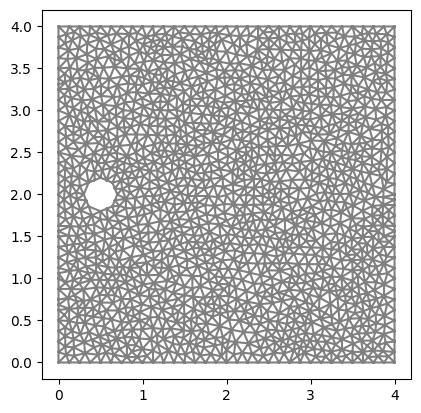

In [ ]:
# Define rectangular domain
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 3)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

### **The domain**
Here, we look at how the solution to the adjoint velocity and adjoint pressure, as well as the refined mesh change with the moving of the centre of the circle. The result of the simulation with the circle in some different places can be seen in Figure 1
![picture](http://drive.google.com/uc?export=view&id=1KJXuRo8384kS2fvbebamEElqOKqjRRhf)

***Fig 1: Mesh refinement, adjoint velocity and adjoint pressure for different placements of the circular hole***

For the circle placed in the center in the y-direction, and to the left in the x-direction, we can see that the mesh refinement area is close to the circle with a bit of a asymmetric part to the left. Also, the adjoint velocity is high in the circle area, and then spirals back arond to the hole. The adjoint pressure is also similar for the whole domain.

Then, when the hole is placed in the middle, the mesh is refined in a elliptical area around the circle. Also, there is a part above an below the circle on the edge of the domain where the mesh is refined. The adjoint velocity is also similar to the previous case, where the flow loops around from the circle and goes back to the circle. There is also a slightly larger difference in pressure compared to when the circle was placed to the left.

Finally, the circle is placed in the upper roight coner. Here, the area of the mesh that is refined is slightly more asymmetrical than in the previous cases. Also, the flow loops around in a bigger loop through the circle, with a less spiral-shaped path. Finally, the adjoint pressure is similar to the previous placement.  

### **The functional**
Here, we look at how chanding the data of the functional changes the mesh refinement and the adjoint pressure and vector. In particular, we look at three cases. these cases are
\begin{cases} \psi_1 = (1,0)\\
\psi_2 = (0)\\
\psi_3 = (0,0)\end{cases}

and

 \begin{cases} \psi_1 = (1,0) \\
\psi_2 = 1 \\
\psi_3 = (1,0) \end{cases}

and

 \begin{cases} \psi_1 = (e^{(-10.0*(x[0]-2.0)^2) + (x[1]-1.5)^2)},0.0) \\
\psi_2 = e^{(-10.0*(x[0]-2.0)^2) + (x[1]-1.0)^2)}\\
\psi_3 = (0,1)\end{cases}

The result of the computations can be found in Figure 2.


![picture](http://drive.google.com/uc?export=view&id=18l-cPvaaxRkp16xv_ugV3b_YxCA1WvrR)

***Fig 2: Adjoint velocity, adjoint pressure and refined mesh for difrent data (psi_1, psi_2, psi_3) for the functional***

We can see for the first case that the adjointvelocity is smal for most of the domain, but larger in the middle of the side opposite to the circular hole. We also see that the adjoint pressure only change with the x-coordinate, and is constant in the y-direction. Themesh refinment is mostly around the circle, with some in the corners of the domain closest to the circle.

In the seccond case, we again have higher adjoint velocity opposite to the circle, but in the opposite direction. The adjoint pressure is also more constant over the hole domain, except for close to the circle. The mesh refinement is also more spread out over the whole domain, bot close to the circle and in the opposite corners of the domain.

In the last case, we unlike the two previous cases have a clear spiral flow for the adjoint velocity, going from the circle and looping back around. Also, there is a larger difference in the adjoint pressure over the domain than in the previous case. The part of the mesh that is refined also somewhat follow the sprial shape made by the adjoint velocity.

**Define and solve variational problems**

In [ ]:
# Set boundary penalty parameter gamma
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
psi2 = Expression("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
#psi1 = Expression(("0.0","1.0"), element = V.ufl_element())
#psi2 = Expression("1.0", element = Q.ufl_element())
phi3 = Expression(("0.0","1.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system
solve(res == 0, w)

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system
solve(res_a == 0, wa)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_29f63fc2f6192c2ea8456e7c194a27721568f319

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              6
  Coefficients:                        '[f_63, f_75, f_76, f_78, f_79, f_80]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                      

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00326204 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0223219 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00482249 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0185256 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_55a2fc928615c00de576df7fa40f1343537f726c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              3
  Coefficients:                        '[f_76, f_78, f_79]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?
                            

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bb1be0e4f3c0e3b86fae8f14d5132771fc0e3c1e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              7
  Coefficients:                        '[f_72, f_76, f_78, f_79, f_81, f_82, f_83]'
  Unique elements:                     'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d67966e0b4802e12b02f9a3e21738e9fb35809b6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              3
  Coefficients:                        '[f_76, f_78, f_79]'
  Unique elements:                     'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG3(?,?
                            

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_759efe45857eda8ec2d86dd9f63aa8fe3026ac5f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0256956 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6374535ba84ea32d2351d1e531a3a93b7a39dbac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00334048 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0151138 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f1123183e51000de7622db02db722391ef7ef0d0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0104339 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0257046 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0107307 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0192206 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00866389 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0232849 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00599551 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0175838 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9b2e964d5788449de7057dfac9249e98d8a03980

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_63]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ce955c558cdf515a986bb7c4f3769c53d2df2fd7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00754666 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0330758 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e60a432166f66faa9cd5096f9105cba41287be48

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0613739 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d26879a248a8c975cfa62b7a3847479a452651b3

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_63]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6bacba20a39b82ebffae6051124447daa417514c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_72]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG3(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG3(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), Vector<2 x CG3(?
                             ,?)>, CG1(?,?), CG3(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e16dab05c681284c648d918fd462681f521a7ad9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00314045 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0193708 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3360108e998ae6355d6beb748d51b96558d65464

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0046382 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0327392 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_96191a7be4ef9d895d5994ee726b78d9e4e3abca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00453067 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0203545 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_25105a09b74ad0649a1b2f8d5ef96f1b61d61b1b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_72]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG3(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG3(?,?)>, CG2(?,?), CG3(?,
                             ?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --

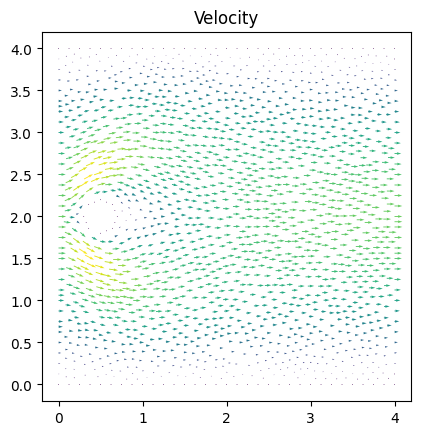

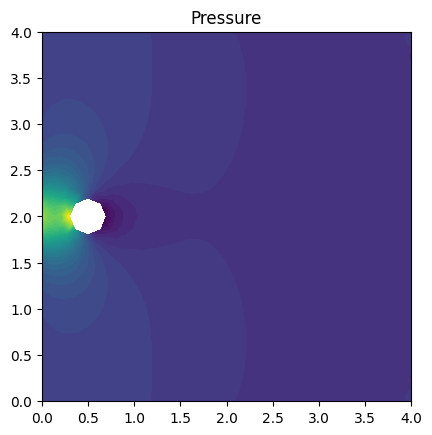

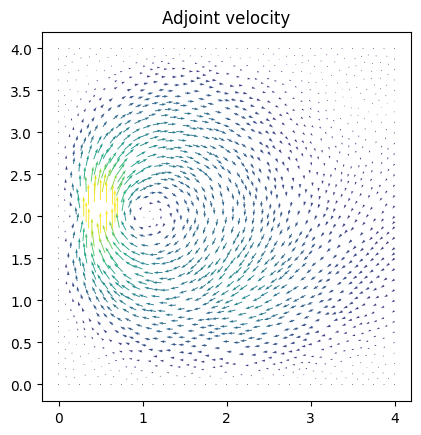

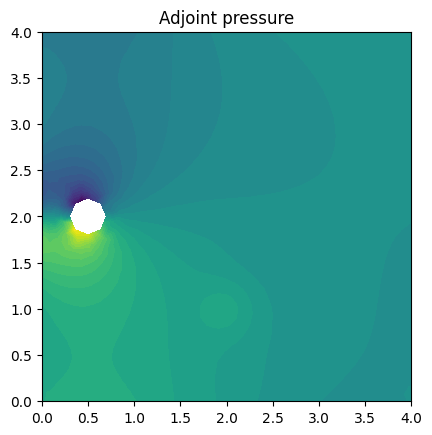

In [ ]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cd40aaaf5bc0b68be1a587d7bb9a08da6d0820e7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00475574 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0193803 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dc7cf94f169c493f79b92d3395ad1a2327538e8f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_63, f_72, f_80]'
  Unique elements:           'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                             <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x CG2(?,?)>,
                              Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                             <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x CG2(?,?)>,
                              Vector<2 x CG1(?,?)>, CG1(?,?), V

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0cef50ccd57d3ff2a8e1828c0c360a5e25dd39c4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00340152 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0133917 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

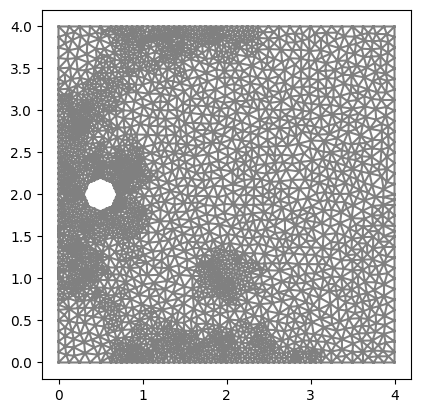

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d23ea9007ad062fa1098213a0d3264a2ae9854d2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              7
  Coefficients:                        '[f_63, f_72, f_75, f_76, f_78, f_79, f_80]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mixed
                                       <Vector<2 x CG3(?,?)>, CG2(?,?)>, Vector<2 x 
                                       CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Mi

Total error = -0.005472953941699361


In [ ]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()]
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err)
print(s)

# **Discussion**

A flow was simulated using Stokes equation and a finite element method. The adjoint stokes equations were also used to compute the local errors, to find where the mesh needed to be refined. Then, the adjoint pressure, adjoint velocity and refined mesh were compared when a circular hole was placed in different places in the domain, as well as changes when the data to the adjoint problem were changed. The results were as expected, with both the position of the circle and the data to the functional influencing how the adjoint pressure, velocity and refined mesh behaved.  